In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [6]:
images = os.listdir('../train')
len(images)/2

5635.0

In [7]:
train_masks = pd.read_csv('../train_masks.csv')
train_masks.head()

,subject,img,pixels
0,1,1,168153 9 168570 15 168984 22 169401 26 169818 ...
1,1,2,96346 7 96762 16 97179 27 97595 35 98012 40 98...
2,1,3,121957 2 122365 26 122784 28 123202 31 123618 ...
3,1,4,110980 9 111393 21 111810 33 112228 43 112647 ...
4,1,5,NaN


In [8]:
import numpy as np
import matplotlib.pyplot as plt

import cv2
from PIL import Image

%matplotlib inline

(0, 255)

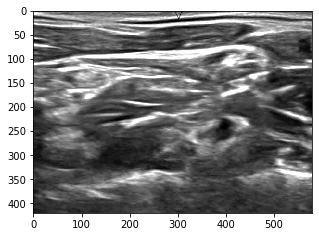

In [9]:
INPUT_IMAGE_PATH = "../train/"
image1 = np.array(Image.open(INPUT_IMAGE_PATH + "1_1" +".tif"))
# image1 = np.expand_dims(image1, axis=2)
plt.figure(figsize=(5,5))
plt.imshow(image1, cmap='gray')
np.min(image1), np.max(image1)

(0, 255)

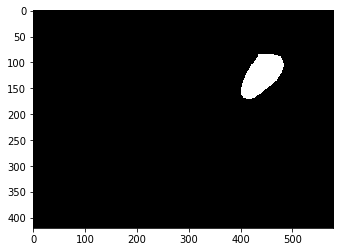

In [10]:
image1_msk = np.array(Image.open(INPUT_IMAGE_PATH + "1_1_mask" +".tif"))

plt.imshow(image1_msk, cmap='gray')
np.min(image1_msk), np.max(image1)

In [11]:
image1.shape, image1_msk.shape

((420, 580), (420, 580))

In [12]:
no_mask = train_masks[train_masks.isnull().any(1)]
no_mask.head()

,subject,img,pixels
4,1,5,NaN
5,1,6,NaN
7,1,8,NaN
8,1,9,NaN
9,1,10,NaN


In [13]:
for index, row in no_mask.iterrows():
    
    image = np.array(Image.open(INPUT_IMAGE_PATH + "{}_{}".format(row['subject'], row['img']) +".tif"))
    
    image_mask = np.zeros(image.shape, dtype=np.uint8)
#     image_mask = 255* image_mask
    
    mask_name = INPUT_IMAGE_PATH + "{}_{}_mask".format(row['subject'], row['img']) +".tif"
#     cv2.imwrite(mask_name, image_mask)

    image = Image.fromarray(image_mask)
    image.save(mask_name)

In [14]:
# Add new columns to train_masks dataframe to store location of image and mask

train_masks['image_location'] = train_masks['subject'].astype(str) + "_" + train_masks['img'].astype(str)
train_masks['mask_location'] = train_masks['subject'].astype(str) + "_" + train_masks['img'].astype(str)

train_masks['image_location'] = INPUT_IMAGE_PATH + train_masks['image_location'] + ".tif"
train_masks['mask_location'] = INPUT_IMAGE_PATH + train_masks['mask_location'] + "_mask.tif"

train_masks['image_location'][0], train_masks['mask_location'][0]

('../train/1_1.tif', '../train/1_1_mask.tif')

In [15]:
train_masks.head()

,subject,img,pixels,image_location,mask_location
0,1,1,168153 9 168570 15 168984 22 169401 26 169818 ...,../train/1_1.tif,../train/1_1_mask.tif
1,1,2,96346 7 96762 16 97179 27 97595 35 98012 40 98...,../train/1_2.tif,../train/1_2_mask.tif
2,1,3,121957 2 122365 26 122784 28 123202 31 123618 ...,../train/1_3.tif,../train/1_3_mask.tif
3,1,4,110980 9 111393 21 111810 33 112228 43 112647 ...,../train/1_4.tif,../train/1_4_mask.tif
4,1,5,NaN,../train/1_5.tif,../train/1_5_mask.tif


0

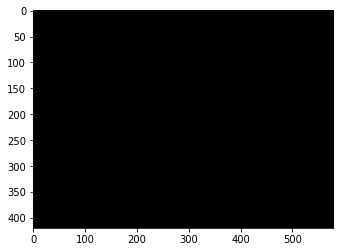

In [16]:
mask = np.array(Image.open(train_masks['mask_location'][4]))
plt.imshow(mask, cmap='gray')
np.sum(mask)

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import array_to_img

BATCH_SIZE_TRAIN = 32

def create_segmentation_generator_train(dataframe, img_col, msk_col, BATCH_SIZE):
    data_gen_args = dict(rescale=1./255
#                      featurewise_center=True,
#                      featurewise_std_normalization=True,
#                      rotation_range=90
#                      width_shift_range=0.2,
#                      height_shift_range=0.2,
#                      zoom_range=0.3
                        )
    datagen = ImageDataGenerator(**data_gen_args)
    
    img_generator = datagen.flow_from_dataframe(dataframe=dataframe, x_col=img_col, target_size=(128, 128), class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE_TRAIN, seed=1)
    msk_generator = datagen.flow_from_dataframe(dataframe=dataframe, x_col=msk_col, target_size=(128, 128), class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE_TRAIN, seed=1)
    return zip(img_generator, msk_generator)

In [18]:
train_generator = create_segmentation_generator_train(train_masks, 'image_location', 'mask_location',32)

Found 5635 validated image filenames.
Found 5635 validated image filenames.


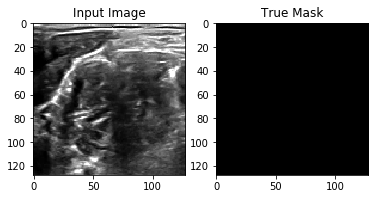

In [19]:
def display(display_list):
    
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(array_to_img(display_list[i]), cmap='gray')
    plt.show()
    
def show_dataset(datagen, num=1):
    for i in range(0,num):
        image,mask = next(datagen)
        display([image[0], mask[0]])
        
show_dataset(train_generator,1)

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
# from tensorflow_examples.models.pix2pix import pix2pix

smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def get_unet():
    inputs = Input((128, 128, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=[dice_coef])

    return model

In [21]:
model = get_unet()

In [22]:
import math
STEPS = math.ceil(5635.0/32)
EPOCHS = 50

In [23]:
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEPS,
                   epochs=EPOCHS)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
177/177 [==============================] - 26s 144ms/step - loss: 0.5204 - dice_coef: 0.0181
Epoch 2/50
177/177 [==============================] - 23s 129ms/step - loss: 0.0937 - dice_coef: 0.0108
Epoch 3/50
177/177 [==============================] - 23s 131ms/step - loss: 0.0451 - dice_coef: 0.0880
Epoch 4/50
177/177 [==============================] - 24s 134ms/step - loss: 0.0431 - dice_coef: 0.1027
Epoch 5/50
177/177 [==============================] - 24s 137ms/step - loss: 0.0417 - dice_coef: 0.1140
Epoch 6/50
177/177 [==============================] - 25s 141ms/step - loss: 0.0410 - dice_coef: 0.1240
Epoch 7/50
177/177 [==============================] - 25s 142ms/step - loss: 0.0396 - dice_coef: 0.1340
Epoch 8/50
177/177 [==============================] - 26s 144ms/step - loss: 0.0384 - dice_coef: 0.1511
Epoch 9/50
177/177 [==============================] - 26s 148ms/step - loss: 0.0369 - dice_c

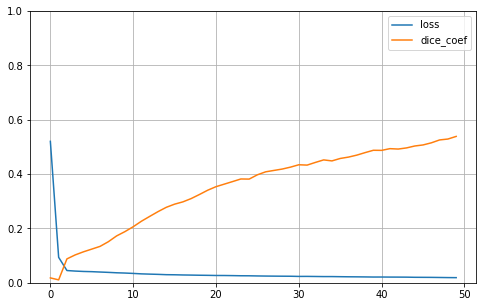

In [24]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Creating the test generator to test the unseen images

In [25]:
TEST_PATH = '/home/ubuntu/ultrasound/test/'

In [26]:
submission_file = pd.read_csv("../sample_submission.csv")
submission_file.head()

,img,pixels
0,1,1 1
1,2,1 1
2,3,1 1
3,4,1 1
4,5,1 1


In [27]:
submission_file['image_location'] = TEST_PATH + submission_file['img'].astype(str) + '.tif'
submission_file.head()

,img,pixels,image_location
0,1,1 1,/home/ubuntu/ultrasound/test/1.tif
1,2,1 1,/home/ubuntu/ultrasound/test/2.tif
2,3,1 1,/home/ubuntu/ultrasound/test/3.tif
3,4,1 1,/home/ubuntu/ultrasound/test/4.tif
4,5,1 1,/home/ubuntu/ultrasound/test/5.tif


In [28]:
# Generates a sequential list of all files
def create_segmentation_generator_test(dataframe, img_col, BATCH_SIZE):
    data_gen_args = dict(rescale=1./255)
    datagen = ImageDataGenerator(**data_gen_args)
    
    img_generator = datagen.flow_from_dataframe(dataframe=dataframe, x_col=img_col, target_size=(128, 128), class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE_TRAIN, seed=1)
    return img_generator

test_generator = create_segmentation_generator_test(submission_file, 'image_location', 32)

Found 5508 validated image filenames.


## Making predictions on the train set to verify that the model works as expected

In [29]:
im, ms = next(train_generator)

### The original image fed as input

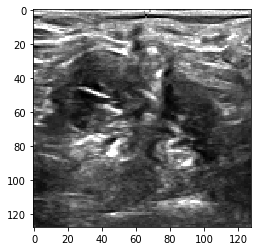

In [30]:
plt.imshow(array_to_img(im[30]), cmap='gray')

### The actual mask

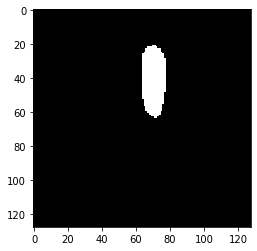

In [31]:

# plt.imshow(array_to_img(im[0]), cmap='gray')
plt.imshow(array_to_img(ms[30]), cmap='gray')

In [32]:
import tensorflow as tf
image_to_predict = tf.expand_dims(im[30], axis=0) # Changing the shape from (128,128,1) to (1,128,128,1)
image_to_predict.shape

TensorShape([1, 128, 128, 1])

### The predicted mask

In [33]:
predicted_image = model.predict(image_to_predict)

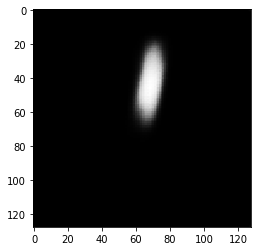

In [34]:
predicted_image = predicted_image[0] # changing the shape from (1,128,128,1) to (128,128,1)
plt.imshow(array_to_img(predicted_image), cmap='gray')

### We see that the mask is pretty close to the actual mask, let's apply threshold to make it look more realistic

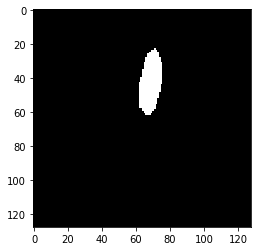

In [35]:
dummy = np.where(predicted_image>0.5, 1, 0) # Applying thresholding to the predicted image
plt.imshow(array_to_img(dummy), cmap='gray')

## Making predictions on the test set

In [36]:
predictions = model.predict_generator(test_generator)

Instructions for updating:
Please use Model.predict, which supports generators.


In [37]:
predictions.shape

(5508, 128, 128, 1)

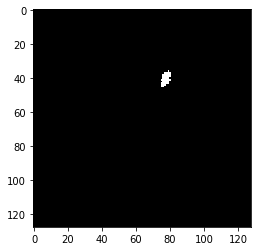

In [38]:
# dummy = predictions[200]>0.1
INDEX = 300
pred_msk = np.where(predictions[INDEX]>=0.5, 1, 0)
plt.imshow(array_to_img(pred_msk), cmap='gray')

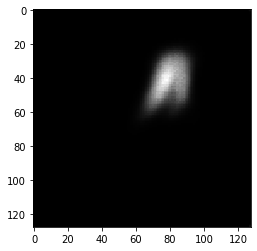

In [39]:
plt.imshow(array_to_img(predictions[INDEX]), cmap='gray')

In [41]:
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

In [42]:

for i in predictions:
    i = np.squeeze(i, axis=2)
    rle = rle_encoding(i)
    break

## Resizing Image

In [67]:
resized_images = tf.image.resize(
    predictions, (420, 580), method='bilinear'
)

resized_images.shape

TensorShape([5508, 420, 580, 1])

In [68]:
resized_images = np.array(resized_images)
resized_images.shape

(5508, 420, 580, 1)

In [92]:
MIN_LENGTH = 10
THRESHOLD = 0.9

In [93]:
rles = []
for i in resized_images:
    np_array = np.squeeze(i, axis=2)
    np_array = np.where(np_array>=THRESHOLD, 1, 0)
    rle = rle_encoding(np_array)
    if len(rle)<=MIN_LENGTH:
        rles.append([])
    else:    
        rles.append(rle)

## Changing the rles from list to a string

In [94]:
rle_string = []
for i in rles:
    string_version = ' '.join(map(str, i))
    rle_string.append(string_version)

In [95]:
submission_file['pixels'] = rle_string
try:
    submission_file.drop(columns=['image_location'],inplace=True)
except:
    print("Couldn't remove image_location from the csv file. the column doens't exist")

Couldn't remove image_location from the csv file. the column doens't exist


In [96]:
submission_file.head()

,img,pixels
0,1,
1,2,
2,3,
3,4,
4,5,


In [97]:
submission_file.to_csv("submission.csv", index = False)